In [1]:
# Francisco Dominguez Mateos
# 26/08/2020
# from: Neural Tangents Cookboock 
#    https://github.com/google/neural-tangents
#    https://colab.research.google.com/github/google/neural-tangents/blob/master/notebooks/neural_tangents_cookbook.ipynb#scrollTo=cIkq2O7yVWYJ

In [2]:
#!pip install -q git+https://www.github.com/google/neural-tangents
#!pip install neural-tangents

In [3]:
import jax.numpy as np

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap

import functools

import neural_tangents as nt
from neural_tangents import stax

In [4]:
#Test if JAX is using CPU or GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [5]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns
  
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

import matplotlib.pyplot as plt

def format_plot(x=None, y=None): 
  # plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=20)
  if y is not None:
    plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

legend = functools.partial(plt.legend, fontsize=10)

In [6]:
def plot_fn(train, test, *fs):
  train_xs, train_ys = train

  plt.plot(train_xs, train_ys, 'ro', markersize=10, label='train')
  
  if test != None:
    test_xs, test_ys = test
    plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

    for f in fs:
      plt.plot(test_xs, f(test_xs), '-', linewidth=3)

  plt.xlim([-np.pi, np.pi])
  plt.ylim([-1.5, 1.5])

  format_plot('$x$', '$f$')

In [7]:
def loss_fn(predict_fn, ys, t, xs=None):
  mean, cov = predict_fn(t=t, get='ntk', x_test=xs, compute_cov=True)
  mean = np.reshape(mean, mean.shape[:1] + (-1,))
  var = np.diagonal(cov, axis1=1, axis2=2)
  ys = np.reshape(ys, (1, -1))

  mean_predictions = 0.5 * np.mean(ys ** 2 - 2 * mean * ys + var + mean ** 2,
                                   axis=1)

  return mean_predictions

In [8]:
key = random.PRNGKey(10)

In [9]:
train_points = 5
test_points = 50
noise_scale = 1e-1

target_fn = lambda x: np.sin(x)

In [10]:
key, x_key, y_key = random.split(key, 3)

train_xs = random.uniform(x_key, (train_points, 1), minval=-np.pi, maxval=np.pi)

train_ys = target_fn(train_xs)
train_ys += noise_scale * random.normal(y_key, (train_points, 1))
train = (train_xs, train_ys)

In [11]:
test_xs = np.linspace(-np.pi, np.pi, test_points)
test_xs = np.reshape(test_xs, (test_points, 1))

test_ys = target_fn(test_xs)
test = (test_xs, test_ys)

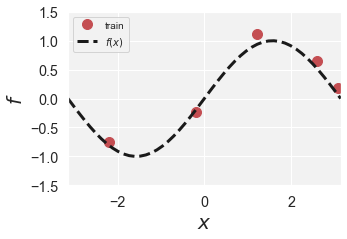

In [12]:
plot_fn(train, test)
legend(loc='upper left')
finalize_plot((0.85, 0.6))

In [13]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(1, W_std=1.5, b_std=0.05)
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnums=(2,))

In [14]:
prior_draws = []
for _ in range(10):
  key, net_key = random.split(key)
  _, params = init_fn(net_key, (-1, 1))
  prior_draws += [apply_fn(params, test_xs)]

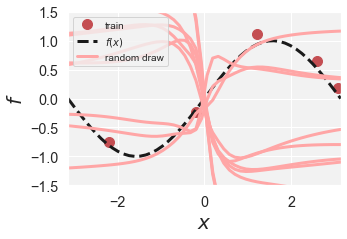

In [15]:
plot_fn(train, test)

for p in prior_draws:
  plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])

legend(['train', '$f(x)$', 'random draw'], loc='upper left')

finalize_plot((0.85, 0.6))

In [16]:
kernel = kernel_fn(test_xs, test_xs, 'nngp')
std_dev = np.sqrt(np.diag(kernel))

/home/francisco/anaconda3/envs/dml3.8/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


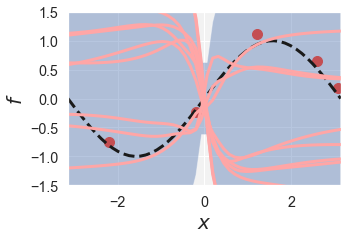

In [17]:
plot_fn(train, test)

plt.fill_between(
    np.reshape(test_xs, (-1,)), 2 * std_dev, -2 * std_dev, alpha=0.4)

for p in prior_draws:
  plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])

finalize_plot((0.85, 0.6))

In [18]:
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, train_xs, 
                                                      train_ys, diag_reg=1e-4)

nngp_mean, nngp_covariance = predict_fn(x_test=test_xs, get='nngp', 
                                        compute_cov=True)

nngp_mean = np.reshape(nngp_mean, (-1,))
nngp_std = np.sqrt(np.diag(nngp_covariance))

/home/francisco/anaconda3/envs/dml3.8/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


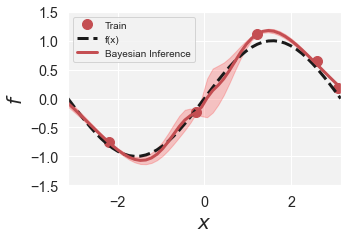

In [19]:
plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    nngp_mean - 2 * nngp_std, 
    nngp_mean +  2 * nngp_std, 
    color='red', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference'], loc='upper left')

finalize_plot((0.85, 0.6))

In [20]:
ntk_mean, ntk_covariance = predict_fn(x_test=test_xs, get='ntk', 
                                      compute_cov=True)

ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_covariance))

/home/francisco/anaconda3/envs/dml3.8/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


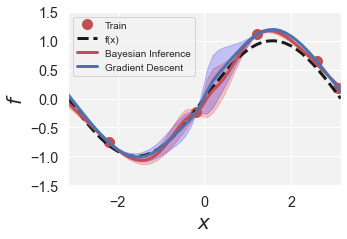

In [22]:
plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    nngp_mean - 2 * nngp_std, 
    nngp_mean +  2 * nngp_std, 
    color='red', alpha=0.2)


plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference', 'Gradient Descent'],
       loc='upper left')

finalize_plot((0.85, 0.6))

In [21]:
ts = np.arange(0, 10 ** 3, 10 ** -1)
ntk_train_loss_mean = loss_fn(predict_fn, train_ys, ts)
ntk_test_loss_mean = loss_fn(predict_fn, test_ys, ts, test_xs)

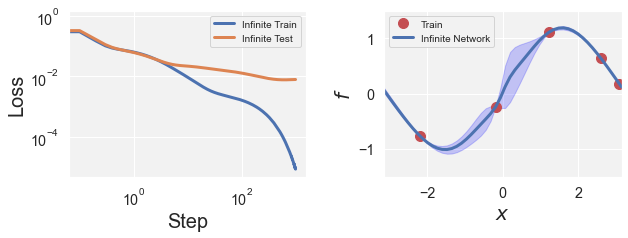

In [22]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)
format_plot('Step', 'Loss')
legend(['Infinite Train', 'Infinite Test'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

legend(
    ['Train', 'Infinite Network'], 
    loc='upper left')

finalize_plot((1.5, 0.6))

In [23]:
learning_rate = 0.1
training_steps = 10000

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

In [24]:
loss = jit(lambda params, x, y: 0.5 * np.mean((apply_fn(params, x) - y) ** 2))
grad_loss = jit(lambda state, x, y: grad(loss)(get_params(state), x, y))

In [25]:
train_losses = []
test_losses = []

opt_state = opt_init(params)

for i in range(training_steps):
  opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)

  train_losses += [loss(get_params(opt_state), *train)]  
  test_losses += [loss(get_params(opt_state), *test)]

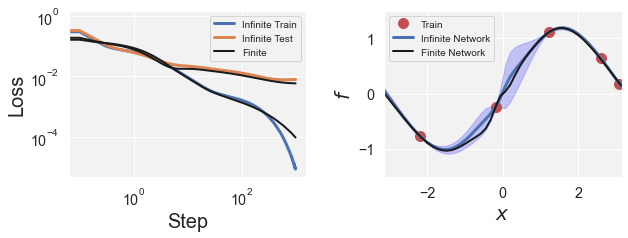

In [26]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, train_losses, 'k-', linewidth=2)
plt.loglog(ts, test_losses, 'k-', linewidth=2)

format_plot('Step', 'Loss')
legend(['Infinite Train', 'Infinite Test', 'Finite'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

plt.plot(test_xs, apply_fn(get_params(opt_state), test_xs), 'k-', linewidth=2)

legend(
    ['Train', 'Infinite Network', 'Finite Network'], 
    loc='upper left')

finalize_plot((1.5, 0.6))

In [27]:
def train_network(key):
  train_losses = []
  test_losses = []

  _, params = init_fn(key, (-1, 1)) 
  opt_state = opt_init(params)

  for i in range(training_steps):
    train_losses += [np.reshape(loss(get_params(opt_state), *train), (1,))]  
    test_losses += [np.reshape(loss(get_params(opt_state), *test), (1,))]
    opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)

  train_losses = np.concatenate(train_losses)
  test_losses = np.concatenate(test_losses)
  return get_params(opt_state), train_losses, test_losses

In [28]:
#@test {"skip": true}
params, train_loss, test_loss = train_network(key)

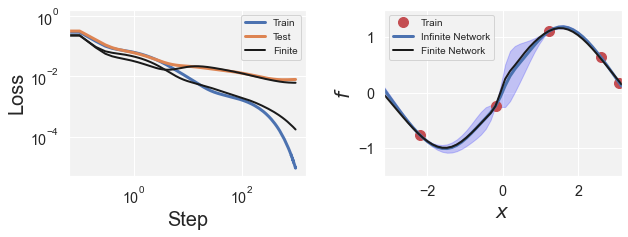

In [29]:
#@test {"skip": true}
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, train_loss, 'k-', linewidth=2)
plt.loglog(ts, test_loss, 'k-', linewidth=2)

format_plot('Step', 'Loss')
legend(['Train', 'Test', 'Finite'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

plt.plot(test_xs, apply_fn(params, test_xs), 'k-', linewidth=2)

legend(['Train', 'Infinite Network', 'Finite Network'], loc='upper left')

finalize_plot((1.5, 0.6))

In [30]:
#@test {"skip": true}
ensemble_size = 100
ensemble_key = random.split(key, ensemble_size)
params, train_loss, test_loss = vmap(train_network)(ensemble_key) 

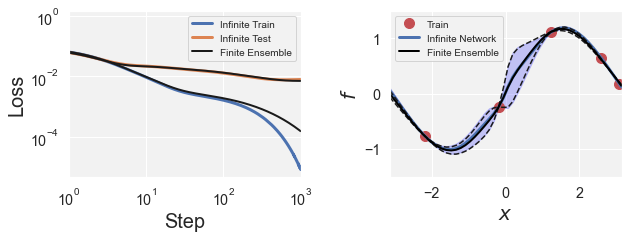

In [31]:
#@test {"skip": true}
plt.subplot(1, 2, 1)

mean_train_loss = np.mean(train_loss, axis=0)
mean_test_loss = np.mean(test_loss, axis=0)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, mean_train_loss, 'k-', linewidth=2)
plt.loglog(ts, mean_test_loss, 'k-', linewidth=2)

plt.xlim([10 ** 0, 10 ** 3])

plt.xscale('log')
plt.yscale('log')
format_plot('Step', 'Loss')

legend(['Infinite Train', 'Infinite Test', 'Finite Ensemble'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

ensemble_fx = vmap(apply_fn, (0, None))(params, test_xs)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(test_xs, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx, linewidth=2, color='black')

legend(['Train', 'Infinite Network', 'Finite Ensemble'], loc='upper left')

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

format_plot('$x$', '$f$')
finalize_plot((1.5, 0.6))

In [32]:
ResBlock = stax.serial(
    stax.FanOut(2),
    stax.parallel(
        stax.serial(
            stax.Erf(),
            stax.Dense(512, W_std=1.1, b_std=0),
        ),
        stax.Identity()
    ),
    stax.FanInSum()
)

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512, W_std=1, b_std=0),
    ResBlock, ResBlock, stax.Erf(),
    stax.Dense(1, W_std=1.5, b_std=0)
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnums=(2,))

In [33]:
#@test {"skip": true}
ensemble_size = 100
learning_rate = 0.1
ts = np.arange(0, 10 ** 3, learning_rate)

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

key, = random.split(key, 1)
ensemble_key = random.split(key, ensemble_size)
params, train_loss, test_loss = vmap(train_network)(ensemble_key) 

In [34]:
#@test {"skip": true}
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, train_xs, 
                                                      train_ys, diag_reg=1e-4)
ntk_mean, ntk_var = predict_fn(x_test=test_xs, get='ntk', compute_cov=True)

ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_var))

ntk_train_loss_mean = loss_fn(predict_fn, train_ys, ts)
ntk_test_loss_mean = loss_fn(predict_fn, test_ys, ts, test_xs)

/home/francisco/anaconda3/envs/jax_gpu/lib/python3.7/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francisco/anaconda3/envs/jax_gpu/lib/python3.7/site-packages/neural_tangents/stax.py:3307: UserWarning: `FanIn` layers assume independent inputs which is not verified in the code. Please make sure to have at least one `Dense` / `Conv` / `GlobalSelfAttention` etc. layer in each branch.
  warnings.warn('`FanIn` layers assume independent inputs which is not verified'


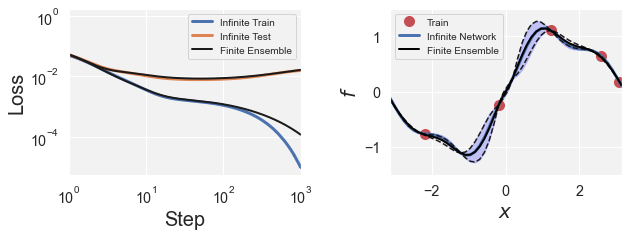

In [35]:
#@test {"skip": true}
plt.subplot(1, 2, 1)

mean_train_loss = np.mean(train_loss, axis=0)
mean_test_loss = np.mean(test_loss, axis=0)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, mean_train_loss, 'k-', linewidth=2)
plt.loglog(ts, mean_test_loss, 'k-', linewidth=2)

plt.xlim([10 ** 0, 10 ** 3])

plt.xscale('log')
plt.yscale('log')
format_plot('Step', 'Loss')

legend(['Infinite Train', 'Infinite Test', 'Finite Ensemble'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

ensemble_fx = vmap(apply_fn, (0, None))(params, test_xs)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(test_xs, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx, linewidth=2, color='black')

legend(['Train', 'Infinite Network', 'Finite Ensemble'], loc='upper left')

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

format_plot('$x$', '$f$')
finalize_plot((1.5, 0.6))